In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from matplotlib.pyplot import figure
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   LabelEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

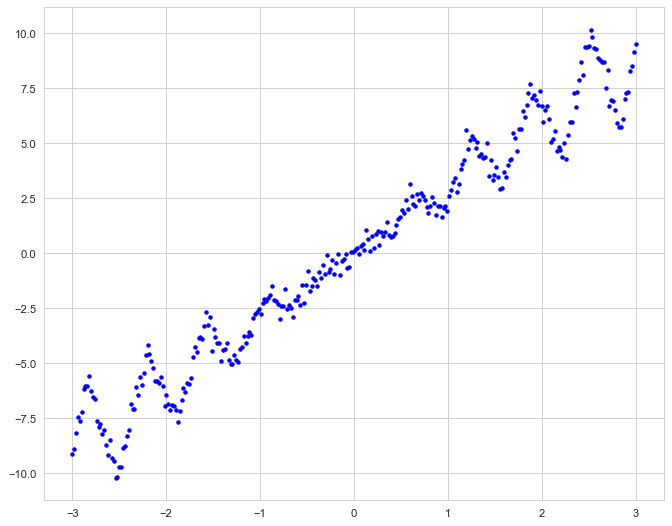

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
figure(figsize=(10, 8), dpi=80)

np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Построение модели:

In [5]:
dtc = DecisionTreeRegressor(max_depth=2, random_state=42) 
dtc.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

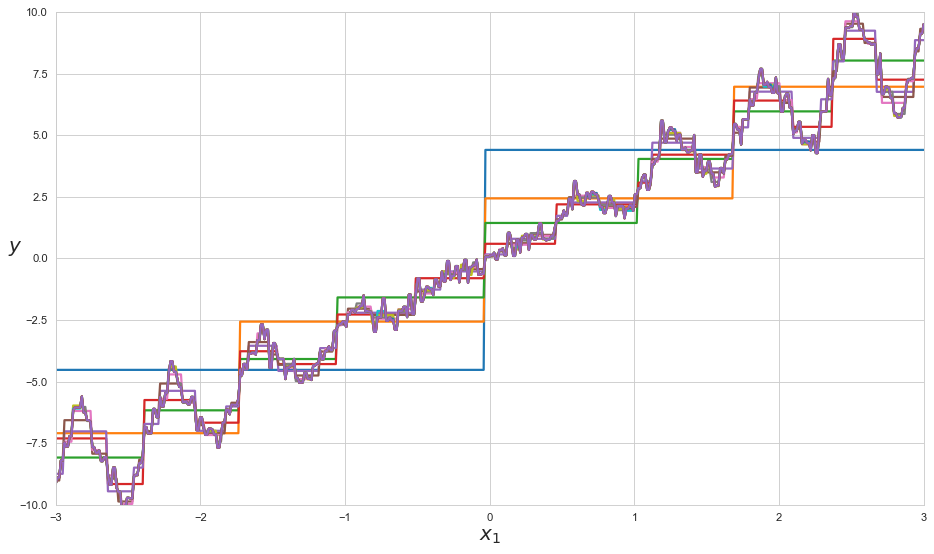

In [6]:
figure(figsize=(14, 8), dpi=80)
for i in range(1, 16):
    dtc = DecisionTreeRegressor(max_depth = i, random_state=42) 
    dtc.fit(X, y)
    plot_regression_predictions(dtc, X, y, axes=[-3, 3, -10, 10], ylabel="$y$")

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [7]:
def get_prob(p):
    total_sum = 0
    for i in range(51, 102):
        total_sum += (math.factorial(101)/(math.factorial(i)*math.factorial(101 - i))) * np.power(p, i) * np.power(1-p, 101-i)
    return total_sum


In [8]:
p = [i/100 for i in range(1, 100)]
total_sums = [get_prob(p_i) for p_i in p]

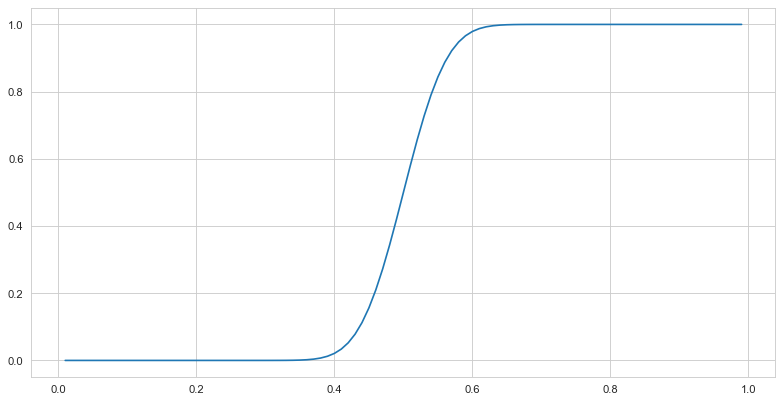

In [9]:
figure(figsize=(12, 6), dpi=80)

plt.plot(p, total_sums)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [10]:
def get_prob(n_models, p=0.65):
    total_sum = 0
    for i in range(n_models//2, n_models):
        total_sum += (math.factorial(n_models)/(math.factorial(i)*math.factorial(n_models - i))) * np.power(p, i) * np.power(1-p, n_models-i)
    return total_sum

In [11]:
get_prob(100)

0.9992621667511374

In [12]:
n_models = [i for i in range(1, 100)]
total_sums = [get_prob(n_i) for n_i in n_models]

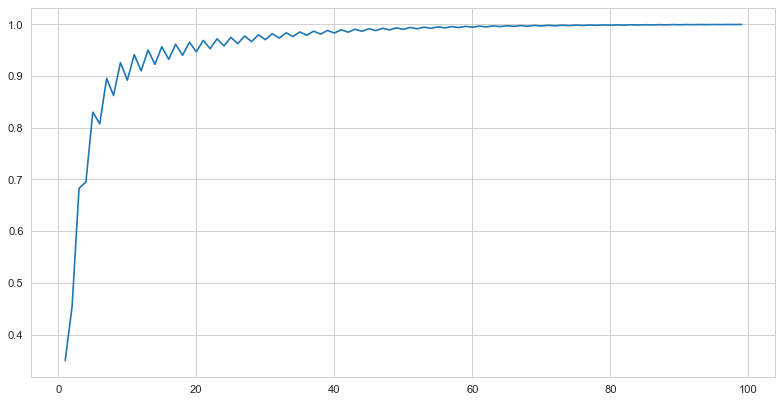

In [13]:
figure(figsize=(12, 6), dpi=80)

plt.plot(n_models, total_sums)
plt.show()

Опишите ваши наблюдения:

* при 0.4 < p < 0.6 вероятность правильно классифицировать объект резко возрастает, а при p > 0.6 вероятность стремится к 1
* при увеличении количества моделей в ансамбле вероятность правильно классифицировать объект логарифмически возрастает

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [14]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=1
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            
            # выбираем признаки для модели
            current_features_ids = random.sample([j for j in range(len(X[0]))], self.max_features)
            self.feat_ids_by_tree.append(current_features_ids)
            
            # делаем превдовыборку
            bootstrap_sample = []
            for X_i in X:
                X_chosen = [X_i[cfi] for cfi in current_features_ids] # выбранные признаки для каждой строки
                bootstrap_sample.append(X_chosen)
                
            # создаем и обучаем модель
            dtc = DecisionTreeClassifier(max_depth = self.max_depth, 
                                        max_features = self.max_features, 
                                        random_state = self.random_state) 
            dtc.fit(bootstrap_sample, y)
            self.trees.append(dtc)
        
        return self

    
    def predict_proba(self, X):
        
        probas_trees = [ [0]*len(self.classes_) for _ in X ]
        
        for i in range(len(self.trees)):
            model = self.trees[i]
            feat_ids = self.feat_ids_by_tree[i]
            
            bootstrap_sample = []
            for X_i in X:
                X_chosen = [X_i[cfi] for cfi in feat_ids]
                bootstrap_sample.append(X_chosen)
            proba = model.predict_proba(bootstrap_sample)
            for row in range(len(proba)):
                for c in self.classes_:
                    probas_trees[row][c] += proba[row][c]
                
        for row in range(len(probas_trees)):
            for c in self.classes_:
                probas_trees[row][c] /= len(self.trees)

        return probas_trees
            
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [15]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

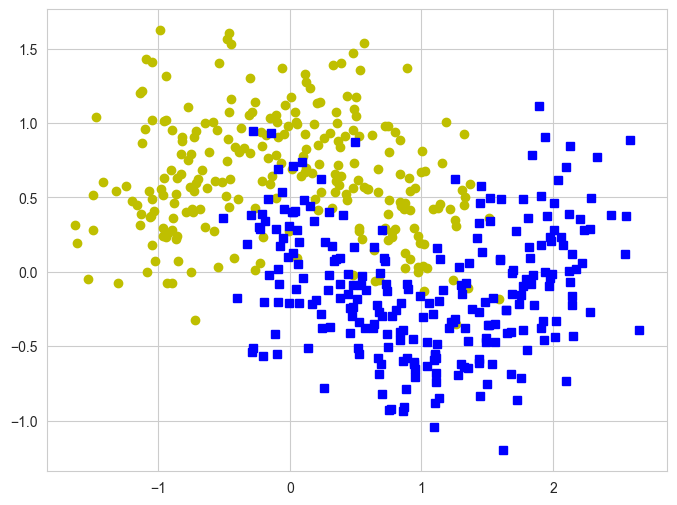

In [16]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

Разделим данные на train и test:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Создадим и обучим модель:

In [18]:
rfcc_model = RandomForestClassifierCustom(max_depth=20, max_features=2)

In [19]:
rfcc_model.fit(X_train, y_train)

RandomForestClassifierCustom(max_depth=20, max_features=2)

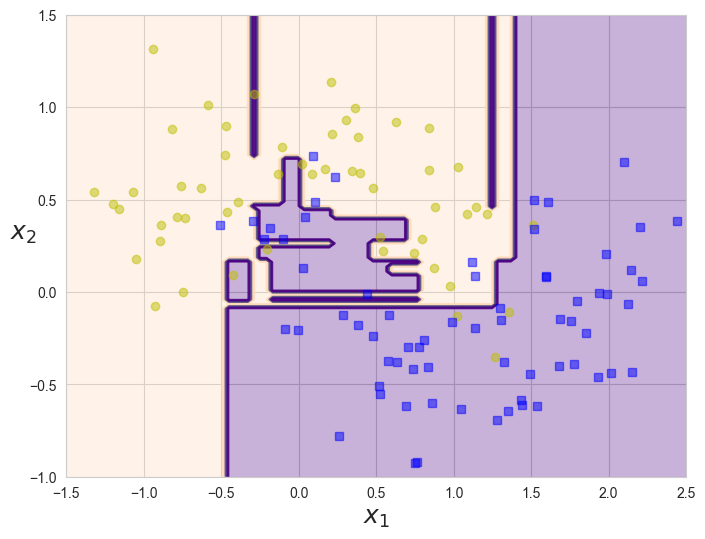

In [20]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(rfcc_model, X_test, y_test)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

Используем GridSearchCV для подбора гиперпараметров (в качестве метрики возьмем f1-score):

In [21]:
params = {'n_estimators':[10, 20, 30, 40, 50, 100, 200, 500, 700, 1000, 1200, 1500], # кол-во деревьев в ансамбле
          'max_depth':[3, 5, 7, 10, 15],
          'max_features':[1, 2]}

In [22]:
%%time

gs_rfcc = GridSearchCV(rfcc_model, params, scoring='f1', n_jobs=-1)
gs_rfcc.fit(X_train, y_train)

CPU times: user 3.48 s, sys: 225 ms, total: 3.7 s
Wall time: 4min 52s


GridSearchCV(estimator=RandomForestClassifierCustom(max_depth=20,
                                                    max_features=2),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15], 'max_features': [1, 2],
                         'n_estimators': [10, 20, 30, 40, 50, 100, 200, 500,
                                          700, 1000, 1200, 1500]},
             scoring='f1')

In [23]:
gs_rfcc.best_params_

{'max_depth': 5, 'max_features': 2, 'n_estimators': 10}

In [24]:
gs_rfcc.best_score_

0.8986641576789959

Строим и обучаем модель с полученными гиперпараметрами:

In [25]:
rfcc_model_new = RandomForestClassifierCustom(n_estimators=40, max_depth=5, max_features=2)
rfcc_model_new.fit(X_train, y_train)

RandomForestClassifierCustom(max_depth=5, max_features=2, n_estimators=40)

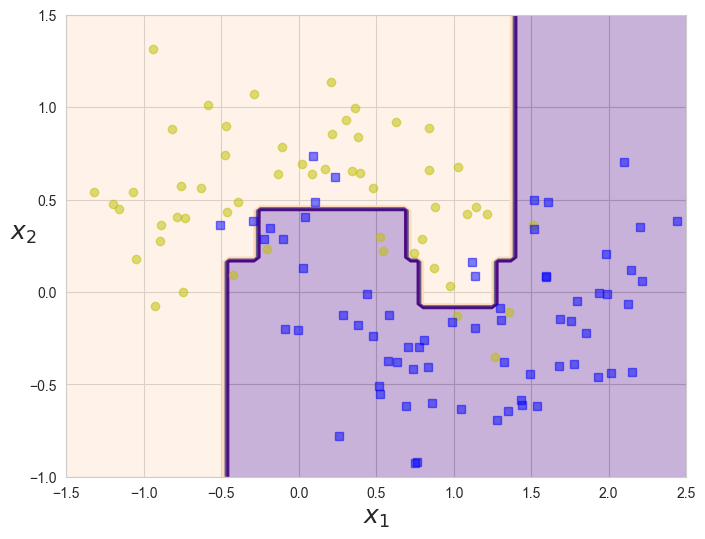

In [26]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(rfcc_model_new, X_test, y_test)

На данном графике разделяющая граница оптимальна с точки зрения bias-variance: модель хорошо описывает данные, но при этом не переобучилась.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [27]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [28]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [29]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
base_model_pair_correlation(rfc, X)

array([0.88439068, 0.86614914, 0.89183304, ..., 0.7876161 , 0.78888505,
       0.85726052])

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [31]:
cols = ['max_depth', 'corr']
df_corr = pd.DataFrame(columns=cols)

In [32]:
max_depth = [2, 3, 5, 7, 10, 12, 15, 20, 25]

for i in max_depth:
    depth_list = []
    corr_list = []
    
    rfc = RandomForestClassifier(max_depth = i)
    rfc.fit(X_train, y_train)
    data_corr = base_model_pair_correlation(rfc, X)
   
    for j in range(len(data_corr)):
        df_corr = df_corr.append({'max_depth': str(i), 'corr':data_corr[j]}, ignore_index=True)

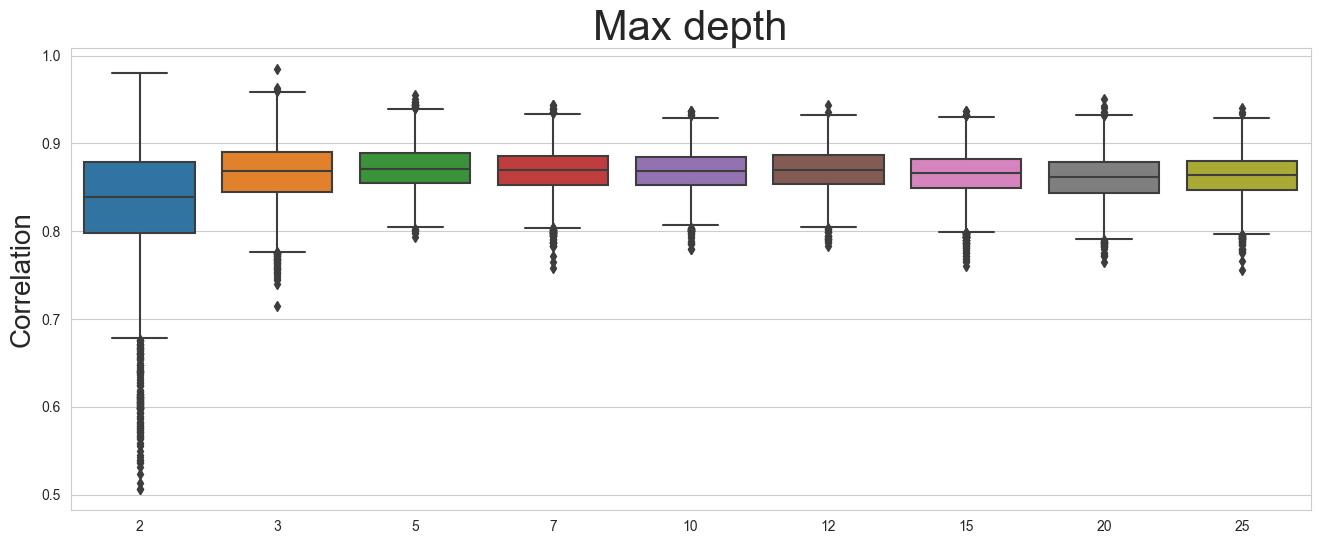

In [33]:
plt.figure(figsize=(16,6))
sns.boxplot(data=df_corr, y="corr", x="max_depth")
plt.xlabel("", size=20)
plt.ylabel("Correlation", size=20)
plt.title("Max depth", size=30)
plt.show()

Опишите ваши наблюдения:

* начиная с параметра max **depth = 3** и выше, корреляции базовых моделей в случайном лесу не меняются и медианы располагаются примерно на отметке **0.87**
* при параметре **max depth = 2** корреляции базовых моделей меньше и медиана равна примерно **0.85**

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [34]:
# !gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [35]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [36]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [37]:
voting_hard = VotingClassifier(estimators = base_models, voting='hard')
voting_soft= VotingClassifier(estimators = base_models, voting='soft')


for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8396975787156666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Curr

VotingClassifier (hard): 0.8395804737268152 \
VotingClassifier (soft): 0.8455110375195781

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [38]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [39]:
voting_hard = voting_hard.fit(X_train, y_train)
voting_soft = voting_soft.fit(X_train, y_train)

In [40]:
base_model_pair_correlation_for_voting_clf(voting_hard, X)

[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  RandomForestClassifier(n_estimators=50, random_state=111),
  0.8593237278777582),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  ExtraTreesClassifier(random_state=111),
  0.7939480300580531),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  KNeighborsClassifier(weights='distance'),
  0.7356706024980413),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(kernel='linear', probability=True, random_state=111),
  0.8125152591475469),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(probability=True, random_state=111),
  0.5049441062502102),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  0.8593484479587904),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  LGBMClassifier(random_state=111),
  0.8560848217397437),


In [41]:
base_model_pair_correlation_for_voting_clf(voting_soft, X)

[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  RandomForestClassifier(n_estimators=50, random_state=111),
  0.8593237278777582),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  ExtraTreesClassifier(random_state=111),
  0.7939480300580531),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  KNeighborsClassifier(weights='distance'),
  0.7356706024980413),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(kernel='linear', probability=True, random_state=111),
  0.8125152591475469),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(probability=True, random_state=111),
  0.5049441062502102),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  0.8593484479587904),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  LGBMClassifier(random_state=111),
  0.8560848217397437),


Уберем некоторые модели \
... \
Тут было много перебора: автоматизированного и не очень \
...

In [42]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
# rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
# etc = ExtraTreesClassifier(random_state=SEED)
# knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
# svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
# cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
# lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
# xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
# nb = GaussianNB()

base_models = [("DT", dt),
               ("SVC_LIN", svc_lin), 
               ("LGBM", lgbm), 
               ("XGB", xgb), 
               ("LR", lr), ]


voting_hard = VotingClassifier(estimators = base_models, voting='hard')
voting_soft= VotingClassifier(estimators = base_models, voting='soft')


for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8396975787156666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Curr

Лучшее значение скора VotingClassifier (voting = 'hard'), который удалось достичь (**0.875**), получилось при следующей **комбинациии алгоритмов**: \
* DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
* SVC(kernel='linear', probability=True, random_state=SEED)
* lightgbm.LGBMClassifier(random_state=SEED)
* xgboost.XGBClassifier(random_state=SEED)
* LogisticRegression(solver='liblinear', max_iter=10000)

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [43]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

В датасете нет пропущенных значений

Категориальные переменные, которые будем трансформировать при помощи OneHotEncoder: \
Area Code, Int'l Plan, VMail Plan, State

Выделяем в отдельные переменные численные, 2 типа категориальных переменных и таргет:

In [45]:
cat_cols = ["Area Code", "Int'l Plan", "VMail Plan", ]
num_cols = ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
       'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls']

all_features = cat_cols + num_cols + ['State']
target = data["Churn?"].values

In [46]:
X = data[all_features]
y = target

Стандартизуем числовые переменные и кодируем OneHotEncoder-ом категориальные:

In [47]:
preprocessor = ColumnTransformer([
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), cat_cols)
])

In [48]:
X_transforms = preprocessor.fit_transform(X)

In [49]:
preprocessor.transformers

[('scaler',
  StandardScaler(),
  ['Account Length',
   'VMail Message',
   'Day Mins',
   'Day Calls',
   'Day Charge',
   'Eve Mins',
   'Eve Calls',
   'Eve Charge',
   'Night Mins',
   'Night Calls',
   'Night Charge',
   'Intl Mins',
   'Intl Calls',
   'Intl Charge',
   'CustServ Calls']),
 ('ohe', OneHotEncoder(), ['Area Code', "Int'l Plan", 'VMail Plan'])]

In [50]:
X_transforms

array([[ 0.67648946,  1.23488274,  1.56676695, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.14906505,  1.30794844, -0.33373776, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.9025285 , -0.59175986,  1.16830364, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.83505538, -0.59175986,  0.01881963, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.08295458, -0.59175986,  0.62477766, ...,  1.        ,
         1.        ,  0.        ],
       [-0.67974475,  1.23488274,  1.00304237, ...,  0.        ,
         0.        ,  1.        ]])

#### Целевая переменная Churn

Изменяем значения целевой переменной на 0 и 1:

In [51]:
le = LabelEncoder()
y_transforms = le.fit_transform(y)

In [52]:
y_transforms

array([0, 0, 0, ..., 0, 0, 0])

Смотрим на количество 0 и 1 в таргете:

In [53]:
unique, counts = np.unique(y_transforms, return_counts=True)
dict(zip(unique, counts))

{0: 2850, 1: 483}

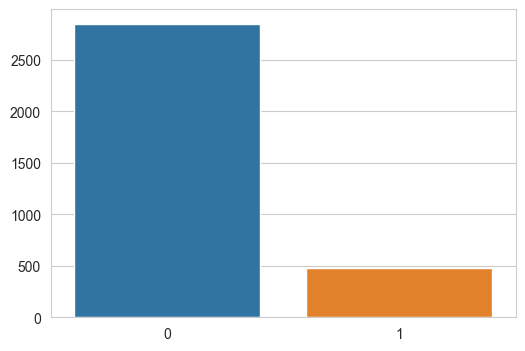

In [54]:
plt.figure(figsize=(6, 4))
sns.barplot(x = unique, y = counts);

Наблюдается дисбаланс классов!

#### Разделим данные на train и test:

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_transforms, y_transforms, test_size = 0.3, random_state=42)

In [56]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

#### Балансировка целевой переменной:

In [57]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [58]:
data.columns

Index(['State', 'Account Length', 'Area Code', 'Phone', 'Int'l Plan',
       'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
       'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls', 'Churn?'],
      dtype='object')

In [59]:
data_for_balancing = pd.concat([pd.DataFrame(X_train), pd.Series(y_train)], axis=1)
data_for_balancing.columns = [*data_for_balancing.columns[:-1], 'Churn?'] # изменяем название целевой переменной

data_balanced = balance_df_by_target(data_for_balancing, 'Churn?')
data_balanced['Churn?'].value_counts()

0    1993
1    1700
Name: Churn?, dtype: int64

In [60]:
X_train_balance = data_balanced.drop(columns='Churn?')
y_train_balance = data_balanced['Churn?']

Функция для вывода нескольких метрик классификации:

In [61]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

### Случайный лес:

#### На изначальных данных с дисбалансом классов

Создаем и обучаем модель:

In [62]:
rfcc_model_churn = RandomForestClassifier()
rfcc_model_churn.fit(X_train, y_train)

RandomForestClassifier()

Попробуем подобрать гиперпараметры к этой модели при помощи GridSearch:

In [63]:
params = {'n_estimators':[10, 20, 30, 40, 50, 100, 200, 500, 700, 1000, 1200, 1500], # кол-во деревьев в ансамбле
          'max_depth':[3, 5, 7, 10, 15],
          'max_features':[1, 2]}

In [64]:
%%time

gs_rfcc_churn = GridSearchCV(rfcc_model_churn, params, scoring='f1', n_jobs=-1)
gs_rfcc_churn.fit(X_train, y_train)

CPU times: user 1.98 s, sys: 197 ms, total: 2.18 s
Wall time: 6min 46s


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15], 'max_features': [1, 2],
                         'n_estimators': [10, 20, 30, 40, 50, 100, 200, 500,
                                          700, 1000, 1200, 1500]},
             scoring='f1')

In [65]:
gs_rfcc_churn.best_params_

{'max_depth': 15, 'max_features': 2, 'n_estimators': 100}

In [66]:
gs_rfcc_churn.best_score_

0.650971250971251

Строим и обучаем модель с полученными гиперпараметрами:

In [67]:
rfcc_model_churn_new = RandomForestClassifier(n_estimators=700, max_depth=15, max_features=2)
rfcc_model_churn_new.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=2, n_estimators=700)

In [68]:
y_pred = rfcc_model_churn_new.predict(X_test)

In [69]:
f1_score(y_test, y_pred, average='macro')

0.811618926018566

In [70]:
f1_score(y_test, y_pred, average='micro')

0.928

Так как в нашем датасете наблюдается дисбаланс классов, необходимо для оценки использовать f1_score 'weighted', чтобы учесть этот дисбаланс и взять взвешенное среднее

In [71]:
f1_score(y_test, y_pred, average='weighted')

0.9173391382612427

#### На данных после балансировки классов

In [72]:
rfcc_model_churn_bal = RandomForestClassifier()
rfcc_model_churn_bal.fit(X_train_balance, y_train_balance)

RandomForestClassifier()

In [73]:
%%time

gs_rfcc_churn_bal = GridSearchCV(rfcc_model_churn_bal, params, scoring='f1', n_jobs=-1)
gs_rfcc_churn_bal.fit(X_train_balance, y_train_balance)

CPU times: user 3.05 s, sys: 411 ms, total: 3.46 s
Wall time: 7min 40s


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15], 'max_features': [1, 2],
                         'n_estimators': [10, 20, 30, 40, 50, 100, 200, 500,
                                          700, 1000, 1200, 1500]},
             scoring='f1')

In [74]:
gs_rfcc_churn_bal.best_params_

{'max_depth': 15, 'max_features': 1, 'n_estimators': 200}

In [75]:
gs_rfcc_churn_bal.best_score_

0.9882922365673202

Строим и обучаем модель с полученными гиперпараметрами:

In [76]:
rfcc_model_churn_bal_new = RandomForestClassifier(n_estimators=50, max_depth=15, max_features=1)
rfcc_model_churn_bal_new.fit(X_train_balance, y_train_balance)

RandomForestClassifier(max_depth=15, max_features=1, n_estimators=50)

In [77]:
y_test_pred = rfcc_model_churn_bal_new.predict(X_test)
y_train_pred = rfcc_model_churn_bal_new.predict(X_train_balance)

get_classification_report(y_train_balance, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1993
           1       1.00      1.00      1.00      1700

    accuracy                           1.00      3693
   macro avg       1.00      1.00      1.00      3693
weighted avg       1.00      1.00      1.00      3693

TEST

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       857
           1       0.94      0.54      0.68       143

    accuracy                           0.93      1000
   macro avg       0.93      0.77      0.82      1000
weighted avg       0.93      0.93      0.92      1000

CONFUSION MATRIX

col_0    0   1
row_0         
0      852   5
1       66  77


In [78]:
f1_score(y_test, y_pred, average='micro')

0.928

**Выводы:**
* до балансировки классов: метрика f1_score 'weighted' = **0.92** (учитываем именно ее, так как важно взять взвешенное среднее (то есть учесть какой класс сколько объектов содержит))
* после балансировки: метрика f1_score 'weighted' = **0.91**, метрика f1_score 'micro' = **0.93** (здесь наверно можно учесть micro, так как дисбаланс классов поправлен)

### LightGBM Classifier

Построим модель с параметрами по умолчанию и посмотрим на score:

In [79]:
model_lgbm = lightgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1993
           1       1.00      1.00      1.00       340

    accuracy                           1.00      2333
   macro avg       1.00      1.00      1.00      2333
weighted avg       1.00      1.00      1.00      2333

TEST

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       857
           1       0.95      0.72      0.82       143

    accuracy                           0.95      1000
   macro avg       0.95      0.86      0.90      1000
weighted avg       0.95      0.95      0.95      1000

CONFUSION MATRIX

col_0    0    1
row_0          
0      852    5
1       40  103


С гиперпараметрами по умолчанию модель предсказывает хорошо)

Но попробуем подобрать гиперпараметры и сделать модель еще лучше \
Для лучшего значения accuracy рекомендуется подобрать значения для гиперпараметров n_estimators и learning_rate:

In [80]:
params_lgbm = {'n_estimators':[20, 30, 50, 100, 150, 200, 500, 700, 1000, 1200, 1500], # кол-во деревьев в ансамбле
          'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5]}

In [81]:
%%time

model_tuned_lgbm = RandomizedSearchCV(model_lgbm, params_lgbm, scoring='f1', n_jobs=-1)
model_tuned_lgbm.fit(X_train, y_train)

CPU times: user 6.21 s, sys: 133 ms, total: 6.35 s
Wall time: 18.1 s


RandomizedSearchCV(estimator=LGBMClassifier(random_state=21), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.5],
                                        'n_estimators': [20, 30, 50, 100, 150,
                                                         200, 500, 700, 1000,
                                                         1200, 1500]},
                   scoring='f1')

In [82]:
model_tuned_lgbm.best_params_

{'n_estimators': 1500, 'learning_rate': 0.05}

In [83]:
model_tuned_lgbm.best_score_

0.8388487288135593

Обучение и оценка новой модели:

In [87]:
model_tuned_lgbm = lightgbm.LGBMClassifier(n_estimators=1500, learning_rate = 0.05,
                                      silent=True, random_state=21)
model_tuned_lgbm.fit(X_train, y_train)

y_train_pred = model_tuned_lgbm.predict(X_train)
y_test_pred = model_tuned_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1993
           1       1.00      1.00      1.00       340

    accuracy                           1.00      2333
   macro avg       1.00      1.00      1.00      2333
weighted avg       1.00      1.00      1.00      2333

TEST

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       857
           1       0.93      0.70      0.80       143

    accuracy                           0.95      1000
   macro avg       0.94      0.85      0.89      1000
weighted avg       0.95      0.95      0.95      1000

CONFUSION MATRIX

col_0    0    1
row_0          
0      850    7
1       43  100


Значения метрик после подбора гиперпараметров немного ухудшились по сравнению с baseline

### CatBoostClassifier

In [85]:
model_cat = catboost.CatBoostClassifier(random_state=21)
model_cat.fit(X_train, y_train)

y_train_pred = model_cat.predict(X_train)
y_test_pred = model_cat.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

Learning rate set to 0.014792
0:	learn: 0.6742704	total: 5.9ms	remaining: 5.9s
1:	learn: 0.6567427	total: 9.56ms	remaining: 4.77s
2:	learn: 0.6443922	total: 13ms	remaining: 4.32s
3:	learn: 0.6318001	total: 16.3ms	remaining: 4.07s
4:	learn: 0.6166955	total: 19.8ms	remaining: 3.93s
5:	learn: 0.6036142	total: 23.1ms	remaining: 3.82s
6:	learn: 0.5914820	total: 26.3ms	remaining: 3.73s
7:	learn: 0.5815611	total: 29.6ms	remaining: 3.67s
8:	learn: 0.5718997	total: 32.7ms	remaining: 3.6s
9:	learn: 0.5613796	total: 36.1ms	remaining: 3.57s
10:	learn: 0.5486105	total: 39.5ms	remaining: 3.55s
11:	learn: 0.5390556	total: 42.7ms	remaining: 3.52s
12:	learn: 0.5277140	total: 46.1ms	remaining: 3.5s
13:	learn: 0.5196354	total: 49.4ms	remaining: 3.48s
14:	learn: 0.5117397	total: 52.5ms	remaining: 3.45s
15:	learn: 0.5023406	total: 55.8ms	remaining: 3.43s
16:	learn: 0.4945287	total: 59ms	remaining: 3.41s
17:	learn: 0.4839459	total: 62.1ms	remaining: 3.39s
18:	learn: 0.4744597	total: 65.7ms	remaining: 3.39s


191:	learn: 0.1665130	total: 791ms	remaining: 3.33s
192:	learn: 0.1661690	total: 796ms	remaining: 3.33s
193:	learn: 0.1660611	total: 800ms	remaining: 3.32s
194:	learn: 0.1656719	total: 805ms	remaining: 3.32s
195:	learn: 0.1653220	total: 810ms	remaining: 3.32s
196:	learn: 0.1649174	total: 814ms	remaining: 3.32s
197:	learn: 0.1645241	total: 819ms	remaining: 3.32s
198:	learn: 0.1641200	total: 823ms	remaining: 3.31s
199:	learn: 0.1637555	total: 826ms	remaining: 3.3s
200:	learn: 0.1633701	total: 829ms	remaining: 3.29s
201:	learn: 0.1630147	total: 833ms	remaining: 3.29s
202:	learn: 0.1626509	total: 838ms	remaining: 3.29s
203:	learn: 0.1622757	total: 841ms	remaining: 3.28s
204:	learn: 0.1619385	total: 844ms	remaining: 3.27s
205:	learn: 0.1616540	total: 847ms	remaining: 3.27s
206:	learn: 0.1613010	total: 850ms	remaining: 3.26s
207:	learn: 0.1609550	total: 854ms	remaining: 3.25s
208:	learn: 0.1605017	total: 861ms	remaining: 3.26s
209:	learn: 0.1602842	total: 865ms	remaining: 3.25s
210:	learn: 0

350:	learn: 0.1327796	total: 1.43s	remaining: 2.65s
351:	learn: 0.1325799	total: 1.44s	remaining: 2.65s
352:	learn: 0.1324515	total: 1.44s	remaining: 2.64s
353:	learn: 0.1323208	total: 1.45s	remaining: 2.64s
354:	learn: 0.1321757	total: 1.45s	remaining: 2.64s
355:	learn: 0.1320479	total: 1.46s	remaining: 2.63s
356:	learn: 0.1318847	total: 1.46s	remaining: 2.63s
357:	learn: 0.1317207	total: 1.47s	remaining: 2.63s
358:	learn: 0.1315788	total: 1.47s	remaining: 2.62s
359:	learn: 0.1314814	total: 1.47s	remaining: 2.62s
360:	learn: 0.1312980	total: 1.48s	remaining: 2.61s
361:	learn: 0.1312002	total: 1.48s	remaining: 2.61s
362:	learn: 0.1310198	total: 1.48s	remaining: 2.6s
363:	learn: 0.1308313	total: 1.49s	remaining: 2.6s
364:	learn: 0.1307389	total: 1.49s	remaining: 2.59s
365:	learn: 0.1306257	total: 1.49s	remaining: 2.59s
366:	learn: 0.1304099	total: 1.5s	remaining: 2.58s
367:	learn: 0.1302294	total: 1.5s	remaining: 2.58s
368:	learn: 0.1300361	total: 1.5s	remaining: 2.57s
369:	learn: 0.129

542:	learn: 0.1088904	total: 2.15s	remaining: 1.81s
543:	learn: 0.1087850	total: 2.15s	remaining: 1.8s
544:	learn: 0.1087406	total: 2.16s	remaining: 1.8s
545:	learn: 0.1085851	total: 2.16s	remaining: 1.8s
546:	learn: 0.1084767	total: 2.17s	remaining: 1.79s
547:	learn: 0.1083773	total: 2.17s	remaining: 1.79s
548:	learn: 0.1082650	total: 2.18s	remaining: 1.79s
549:	learn: 0.1081773	total: 2.18s	remaining: 1.78s
550:	learn: 0.1080859	total: 2.19s	remaining: 1.78s
551:	learn: 0.1079334	total: 2.19s	remaining: 1.78s
552:	learn: 0.1079104	total: 2.19s	remaining: 1.77s
553:	learn: 0.1077150	total: 2.2s	remaining: 1.77s
554:	learn: 0.1075883	total: 2.2s	remaining: 1.76s
555:	learn: 0.1075285	total: 2.2s	remaining: 1.76s
556:	learn: 0.1075104	total: 2.21s	remaining: 1.75s
557:	learn: 0.1072730	total: 2.21s	remaining: 1.75s
558:	learn: 0.1071394	total: 2.21s	remaining: 1.75s
559:	learn: 0.1070728	total: 2.22s	remaining: 1.75s
560:	learn: 0.1069851	total: 2.23s	remaining: 1.74s
561:	learn: 0.1068

713:	learn: 0.0932112	total: 2.8s	remaining: 1.12s
714:	learn: 0.0930833	total: 2.81s	remaining: 1.12s
715:	learn: 0.0928991	total: 2.82s	remaining: 1.12s
716:	learn: 0.0928329	total: 2.82s	remaining: 1.11s
717:	learn: 0.0926250	total: 2.83s	remaining: 1.11s
718:	learn: 0.0925666	total: 2.83s	remaining: 1.11s
719:	learn: 0.0924745	total: 2.83s	remaining: 1.1s
720:	learn: 0.0924398	total: 2.84s	remaining: 1.1s
721:	learn: 0.0923754	total: 2.85s	remaining: 1.09s
722:	learn: 0.0922541	total: 2.85s	remaining: 1.09s
723:	learn: 0.0921174	total: 2.85s	remaining: 1.09s
724:	learn: 0.0919816	total: 2.86s	remaining: 1.08s
725:	learn: 0.0919042	total: 2.86s	remaining: 1.08s
726:	learn: 0.0917818	total: 2.87s	remaining: 1.08s
727:	learn: 0.0916986	total: 2.87s	remaining: 1.07s
728:	learn: 0.0915857	total: 2.87s	remaining: 1.07s
729:	learn: 0.0914398	total: 2.88s	remaining: 1.06s
730:	learn: 0.0913988	total: 2.88s	remaining: 1.06s
731:	learn: 0.0912299	total: 2.88s	remaining: 1.05s
732:	learn: 0.0

873:	learn: 0.0796462	total: 3.4s	remaining: 490ms
874:	learn: 0.0795407	total: 3.41s	remaining: 487ms
875:	learn: 0.0794092	total: 3.41s	remaining: 483ms
876:	learn: 0.0793321	total: 3.42s	remaining: 479ms
877:	learn: 0.0792332	total: 3.42s	remaining: 475ms
878:	learn: 0.0790610	total: 3.42s	remaining: 472ms
879:	learn: 0.0790373	total: 3.43s	remaining: 468ms
880:	learn: 0.0789432	total: 3.43s	remaining: 464ms
881:	learn: 0.0789171	total: 3.44s	remaining: 460ms
882:	learn: 0.0788187	total: 3.44s	remaining: 456ms
883:	learn: 0.0787354	total: 3.44s	remaining: 452ms
884:	learn: 0.0786137	total: 3.45s	remaining: 448ms
885:	learn: 0.0785872	total: 3.45s	remaining: 444ms
886:	learn: 0.0784723	total: 3.45s	remaining: 440ms
887:	learn: 0.0783993	total: 3.46s	remaining: 436ms
888:	learn: 0.0782810	total: 3.46s	remaining: 432ms
889:	learn: 0.0782226	total: 3.46s	remaining: 428ms
890:	learn: 0.0781786	total: 3.47s	remaining: 424ms
891:	learn: 0.0780484	total: 3.47s	remaining: 420ms
892:	learn: 0

CatBoost при значениях гиперпараметров по умолчанию так же показал высокие значения метрик

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [86]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**